In [1]:
import pandas as pd 
import numpy as np
import math
import itertools
from itertools import compress
import geopandas as gpd
import pickle
import xgboost as xgb
import polars
import os
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import math

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import polars
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, roc_auc_score


import sys
import os

sys.path.append('scripts')

In [2]:
kdprov = '32'

In [3]:
# Parameters
kdprov = 73


In [4]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [5]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/fulldataset_VH.pkl', 'rb') as file:
    dt_full=pickle.load(file).to_pandas()

In [6]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl', 'rb') as file:
    xg_dt=pickle.load(file)

In [7]:
cluster=np.sort(dt_full.cluster_data.unique())

In [8]:
dict_predict={}
for cl in cluster:
    print('Predicting for cluster:',cl)
    start_time = time()
    dt_cl=dt_full.query('cluster_data==@cl')
    y = dt_cl.observation
    X = dt_cl.loc[:,'VH_30':'VH_0']
    X['nth'] = dt_cl.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    model=xg_dt[cl]['model']
    dtest = xgb.DMatrix(X, enable_categorical=True)
    y_pred_prob=model.predict(dtest)
    y_pred=y_pred_prob.argmax(axis=1)
    dt_pred=dt_cl[['idpoint', 'idsubsegment', 'idsegment','periode', 'observation','idkabkota', 'cluster_data']]
    dt_pred['prediction']=y_pred
    score={}
    score['accuracy']=accuracy_score(y, y_pred)
    score['f1_macro']=f1_score(y, y_pred, average='macro')
    score['f1_micro']=f1_score(y, y_pred, average='micro')
    score['auc']=roc_auc_score(y,y_pred_prob, multi_class='ovr')
    score['acc_generative']=akurasi_kelas_generatif(y, y_pred)
    score['acc_fase_padi']=akurasi_fase_padi(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    score['relative_acc']=relative_acc
    print(score)
    print(cm)
    end_time = time()
    elapsed_time = end_time - start_time
    print('Finish with processed time:',elapsed_time)
    dict_predict[cl]={'data_prediction':dt_pred,
                        'score':score,
                    'time':elapsed_time}

Predicting for cluster: 0


{'accuracy': 0.607897938492734, 'f1_macro': np.float64(0.5919799184958592), 'f1_micro': np.float64(0.607897938492734), 'auc': np.float64(0.8695145514111224), 'acc_generative': 0.672514811031665, 'acc_fase_padi': 0.6451568285443251, 'relative_acc': np.float64(97.6839585624282)}
[[231704  11909   8541   9334  29051  29589  26972]
 [ 14021 128724  26726   3509    791  19507  11072]
 [  7239  20456 109472  26487   1213   1515  11168]
 [  9832   1197  23430 164598  29359   1745  14589]
 [ 26410    910   1083  20643 124283   5817  11179]
 [ 38997  20966   5083   1783   6050  67635  10011]
 [ 44620   7730   8063  11746   9254  10518  72969]]
Finish with processed time: 11.295066833496094
Predicting for cluster: 1


{'accuracy': 0.5539707817846802, 'f1_macro': np.float64(0.529868433295354), 'f1_micro': np.float64(0.5539707817846802), 'auc': np.float64(0.839090788406243), 'acc_generative': 0.5305927342256214, 'acc_fase_padi': 0.5214841140095244, 'relative_acc': np.float64(97.03481737064449)}
[[ 66143   6007   2491   2310   7706  14925  39643]
 [  3480  46401  11549   1072   1631  12723  16419]
 [  2227   8558  44828   7913    343   1128  14578]
 [  2035    381  12816  55500   9699   2747  21422]
 [  4526    721    161  10031  36690   7046  15100]
 [  2066   4039    231    471   2991  20008   6169]
 [ 30791   8683   7834   8792   8694  16744 151337]]
Finish with processed time: 7.445417404174805
Predicting for cluster: 2


{'accuracy': 0.4365747230386615, 'f1_macro': np.float64(0.41226958397279584), 'f1_micro': np.float64(0.4365747230386615), 'auc': np.float64(0.7835234075459947), 'acc_generative': 0.40896583143507975, 'acc_fase_padi': 0.37915500685871056, 'relative_acc': np.float64(92.70313830434253)}
[[70319  4059  7396  2971  5427 15589 27939]
 [ 6898 12303  5936   771   179  6732  7431]
 [ 4249  2726 20326  4602   325  2262  7485]
 [ 6059   422  6954 22442  4019  2625 12354]
 [10603   249  1683  4754 14030  3779 10052]
 [ 4605  1389   852   230   303 11643  2853]
 [27629  3616 10636  5314  2957 12289 42034]]
Finish with processed time: 5.431759357452393
Predicting for cluster: 3


{'accuracy': 0.6728323627027365, 'f1_macro': np.float64(0.6703101100647268), 'f1_micro': np.float64(0.6728323627027365), 'auc': np.float64(0.9090062780575341), 'acc_generative': 0.7360868722125267, 'acc_fase_padi': 0.7046787287101396, 'relative_acc': np.float64(99.26167758867379)}
[[78419  5390  2030  1821 13917 16804 12919]
 [ 1774 91466 13480   895   277 12924  6884]
 [  916 14878 67631 13521   488   203  6138]
 [ 1181   493 13397 94900 12223   129  6602]
 [12900   218   236 12182 78030   930  6279]
 [18411 14537   477   320   869 61308  6603]
 [ 7291  5530  3693  4540  4188  2739 65469]]
Finish with processed time: 5.297869443893433
Predicting for cluster: 4


{'accuracy': 0.6207464114832536, 'f1_macro': np.float64(0.6022145740558437), 'f1_micro': np.float64(0.6207464114832536), 'auc': np.float64(0.8569253504642119), 'acc_generative': 0.6395571428571428, 'acc_fase_padi': 0.6129134194512651, 'relative_acc': np.float64(97.74614813217357)}
[[70503  2281   842  1888  3907  2741 13538]
 [ 2938 43121  6153  1006   747  2631  9154]
 [ 1660  6673 25632  6744   338   110  6993]
 [ 2328   943  4855 44769  7080   140  9885]
 [ 5480   528   293  4807 30007  2010  7150]
 [ 6086  5831   150   448  1979 11670  4211]
 [20747  7171  2861  6552  5010  1455 66204]]
Finish with processed time: 4.986986875534058
Predicting for cluster: 5


{'accuracy': 0.6339960508089947, 'f1_macro': np.float64(0.6146530057215015), 'f1_micro': np.float64(0.6339960508089947), 'auc': np.float64(0.8784191286648037), 'acc_generative': 0.6559790280298448, 'acc_fase_padi': 0.6528710061858011, 'relative_acc': np.float64(98.316093391751)}
[[168224   6019   2807   3908  12003  12331  14633]
 [  7993  72121  14252   1477    913  11105   7464]
 [  5240  10844  63179  13496    423    536   6057]
 [  5556    554  10093  81325  17392    770   8285]
 [ 12671    747    408   6942  70981   2847   6854]
 [ 12791   8849    439   1070   5045  39905   4026]
 [ 40016   8165   5282   8296   6971   4902  42068]]
Finish with processed time: 7.41437840461731
Predicting for cluster: 6


{'accuracy': 0.7035947779254866, 'f1_macro': np.float64(0.6921522927666033), 'f1_micro': np.float64(0.7035947779254866), 'auc': np.float64(0.9313991780148019), 'acc_generative': 0.7291193234050377, 'acc_fase_padi': 0.7236369353317262, 'relative_acc': np.float64(99.53309292156767)}
[[79175  2583  1869  1196 11152 10484 12466]
 [ 2082 89438 13963   600   144  9485  8988]
 [  878 11529 78907 10752   130    17  8712]
 [  837    80 14507 99142 13022    20  8367]
 [11332   106   120  8981 77724   510  6677]
 [13263 11572   936   162  1356 52613  6648]
 [ 3220  1754  1530  2416  1952   993 39035]]
Finish with processed time: 7.966089963912964


In [9]:
pivot_kabkota=[]
cm_prediction={}
df_for_estimation=[]
for cl in cluster:
    print('Running for cluster:',cl)
    df_pred=dict_predict[cl]['data_prediction']
    df_pred_dom=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['prediction'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_obs=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['observation'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_dom_obs=df_pred_dom.merge(df_pred_obs).rename(columns={'prediction':'dom_pred'})
    df_pred['idpoint_loc']=df_pred.idpoint.apply(lambda y:y.split('#')[1])
    df_pred_center=df_pred.query('idpoint_loc=="13"')[['idsubsegment', 'idkabkota','periode','prediction']]
    df_pred_center_obs=df_pred_center.merge(df_pred_obs).rename(columns={'prediction':'center_pred'})
    df_pred_subsegment=df_pred_center_obs.merge(df_pred_dom_obs)
    df_for_estimation.append(df_pred_subsegment)
    for idkab in df_pred.idkabkota.unique():
        #print('Get Metrics for Each Point Prediction')
        score={}
        score['idkabkota']=[idkab]
        y=df_pred.query('idkabkota==@idkab')['observation']
        y_pred=df_pred.query('idkabkota==@idkab')['prediction']
        score['accuracy_titik']=[accuracy_score(y, y_pred)]
        score['f1_macro_titik']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_titik']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_titik']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_titik']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_titik']=[relative_acc]
        cm_titik=cm
        
        y=df_pred_dom_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_dom_obs.query('idkabkota==@idkab')['dom_pred']
        
        #print('Get Metrics for Dominant Prediction')
        score['accuracy_dom']=[accuracy_score(y, y_pred)]
        score['f1_macro_dom']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_dom']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_dom']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_dom']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_dom']=[relative_acc]
        cm_dom=cm
        
        #print('Get Metrics for Center Point Prediction')
        y=df_pred_center_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_center_obs.query('idkabkota==@idkab')['center_pred']
        score['accuracy_center']=[accuracy_score(y, y_pred)]
        score['f1_macro_center']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_center']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_center']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_center']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_center']=[relative_acc]
        cm_center=cm
        cm_prediction[idkab]={'point':cm_titik,'dominant':cm_dom,'center':cm_center}
        pivotal_df=pd.DataFrame(score)
        pivot_kabkota.append(pivotal_df)
        #df_for_estimation.append()
pivot_kabkota=pd.concat(pivot_kabkota)
df_for_estimation=pd.concat(df_for_estimation)

Running for cluster: 0


Running for cluster: 1


Running for cluster: 2


Running for cluster: 3


Running for cluster: 4


Running for cluster: 5


Running for cluster: 6


In [10]:
with open(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_pivot_cm.pkl', 'wb') as file:
    pickle.dump({'pivot':pivot_kabkota,'cm':cm_prediction,'df_for_est':df_for_estimation},file)

In [11]:
dict_date={
    '2022_03':'2022_01',
    '2022_05':'2022_02',
    '2022_08':'2022_03',
    '2022_10':'2022_04',
    '2022_13':'2022_05',
    '2022_15':'2022_06',
    '2022_18':'2022_07',
    '2022_20':'2022_08',
    '2022_23':'2022_09',
    '2022_25':'2022_10',
    '2022_28':'2022_11',
    '2022_30':'2022_12',
    '2023_03':'2023_01',
    '2023_05':'2023_02',
    '2023_08':'2023_03',
    '2023_10':'2023_04',
    '2023_13':'2023_05',
    '2023_15':'2023_06',
    '2023_18':'2023_07',
    '2023_20':'2023_08',
    '2023_23':'2023_09',
    '2023_25':'2023_10',
    '2023_28':'2023_11',
    '2023_30':'2023_12'
}

In [12]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:dict_date[y])

In [13]:
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')

In [14]:
cm_period={}
acc_fase_period={}
for i in df_for_estimation.periode.unique():
    df_x=df_for_estimation.query('periode==@i')
    y_true=df_x['observation']
    y_pred_center=df_x['center_pred']
    y_pred_dom=df_x['dom_pred']
    cm_center = confusion_matrix(y_true, y_pred_center)
    cm_dom = confusion_matrix(y_true, y_pred_dom)
    cm_center= cm_center.astype('float') / cm_center.sum(axis=1, keepdims=True) * 100
    cm_dom= cm_dom.astype('float') / cm_dom.sum(axis=1, keepdims=True) * 100
    cm=cm_center
    relative_acc_center = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    cm=cm_dom
    relative_acc_dom = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    
    cm_period[i]={'center':cm_center,'dom':cm_dom}
    acc_center=[]
    acc_dom=[]
    for j in range(7):
        acc_center.append(cm_center[j,j])
        acc_dom.append(cm_dom[j,j])
    acc_center.append(accuracy_score(y_true, y_pred_center))
    acc_dom.append(accuracy_score(y_true, y_pred_dom))
    acc_center.append(akurasi_fase_padi(y_true, y_pred_center))
    acc_dom.append(akurasi_fase_padi(y_true, y_pred_dom))
    acc_center.append(relative_acc_center)
    acc_dom.append(relative_acc_dom)
    acc_fase_period[i]={'center':acc_center,'dom':acc_dom}

In [15]:
acc_fase_data=pd.DataFrame(acc_fase_period).T.reset_index()
acc_fase_data['center']=acc_fase_data.center.apply(lambda y: np.array(y))
acc_fase_data['dom']=acc_fase_data.dom.apply(lambda y: np.array(y))

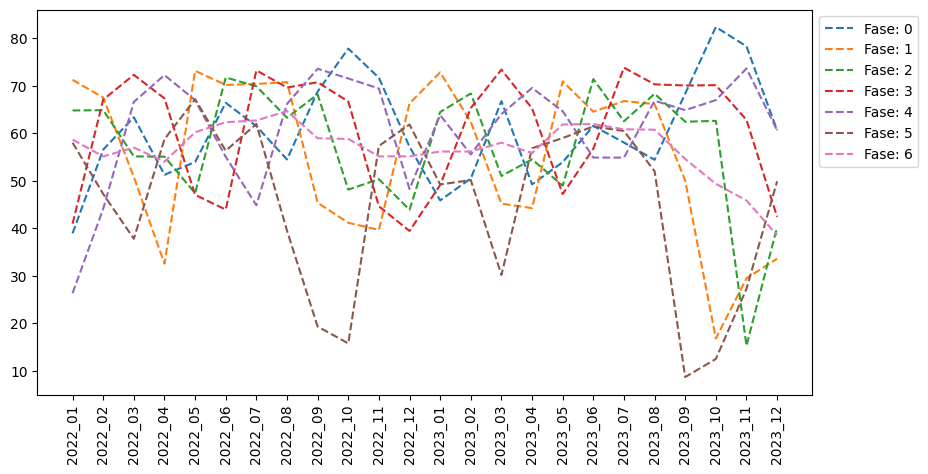

In [16]:
fase0=[]
fase1=[]
fase2=[]
fase3=[]
fase4=[]
fase5=[]
fase6=[]
for i in range(acc_fase_data.shape[0]):
    fase0.append(acc_fase_data['center'][i][0])
    fase1.append(acc_fase_data['center'][i][1])
    fase2.append(acc_fase_data['center'][i][2])
    fase3.append(acc_fase_data['center'][i][3])
    fase4.append(acc_fase_data['center'][i][4])
    fase5.append(acc_fase_data['center'][i][5])
    fase6.append(acc_fase_data['center'][i][6])
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, fase0, linestyle='--', label='Fase: 0', color='tab:blue')
plt.plot(x, fase1, linestyle='--', label='Fase: 1', color='tab:orange')
plt.plot(x, fase2, linestyle='--', label='Fase: 2', color='tab:green')
plt.plot(x, fase3, linestyle='--', label='Fase: 3', color='tab:red')
plt.plot(x, fase4, linestyle='--', label='Fase: 4', color='tab:purple')
plt.plot(x, fase5, linestyle='--', label='Fase: 5', color='tab:brown')
plt.plot(x, fase6, linestyle='--', label='Fase: 6', color='tab:pink')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

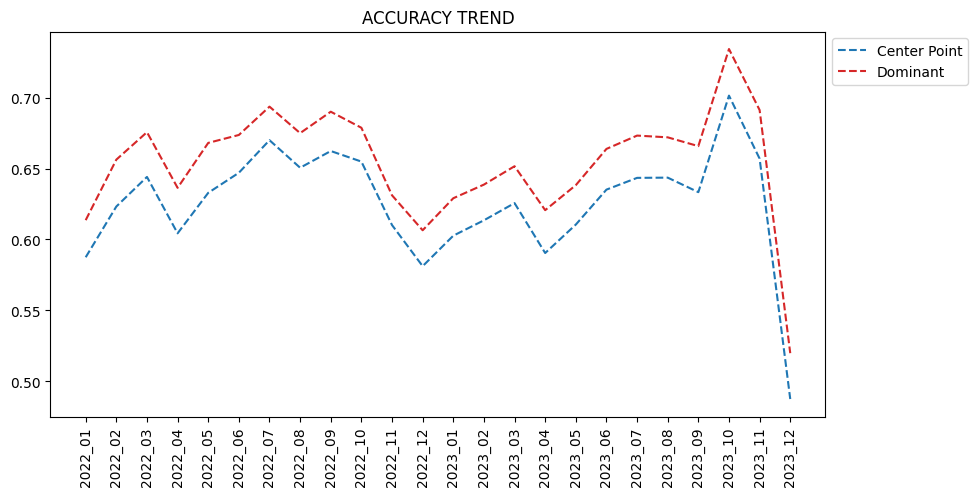

In [17]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][7])
    acc_dom.append(acc_fase_data['dom'][i][7])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

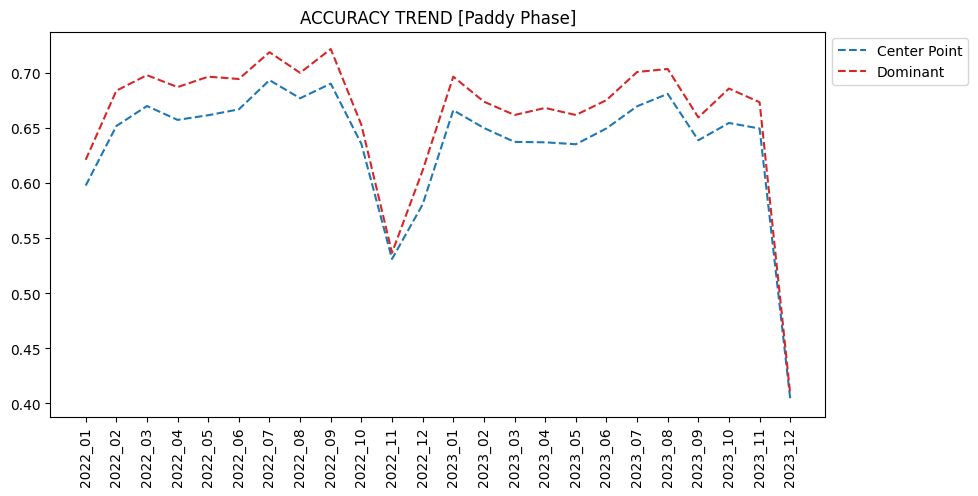

In [18]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][8])
    acc_dom.append(acc_fase_data['dom'][i][8])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_paddy_tred.png', dpi=300, bbox_inches='tight')
plt.show()

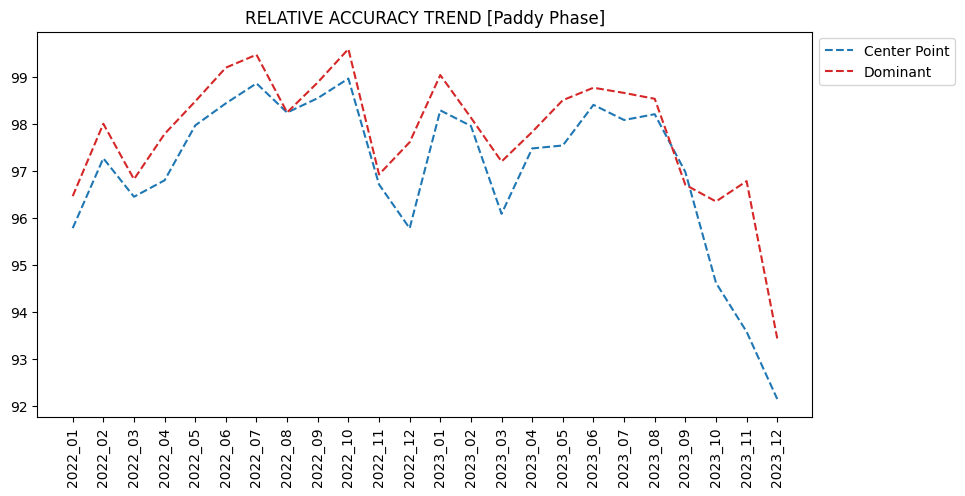

In [19]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][9])
    acc_dom.append(acc_fase_data['dom'][i][9])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('RELATIVE ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_relacc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

In [20]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:y.replace('_',''))
df_for_estimation['id_segmen']=df_for_estimation.idsubsegment.apply(lambda y:y[:9])
df_for_estimation['subsegmen']=df_for_estimation.idsubsegment.apply(lambda y:y[9:])
df_for_estimation['tahun']=df_for_estimation.periode.apply(lambda y: y[:4])
df_for_estimation['bulan']=df_for_estimation.periode.apply(lambda y: y[4:])
df_for_estimation['fase_obs']=df_for_estimation.observation
df_for_estimation['fase_pred']=df_for_estimation.center_pred
df_for_estimation['fase_dom']=df_for_estimation.dom_pred
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')